## Predicting drive failure with XGBoost and RAPIDS

**Dataset**: Hard disk SMART data and failure dataset from Backblaze ([More information](https://www.backblaze.com/b2/hard-drive-test-data.html))

**Task**: Predict hard disk failure with RAPIDS

In [1]:
import time
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

from sklearn.metrics import *
import matplotlib.pyplot as plt
%matplotlib inline

# RAPIDS
import cudf
import xgboost as xgb

### 1. Load Data

#### Training Data

Use Pandas to load training data from CSV ([download link](https://s3-ap-southeast-1.amazonaws.com/deeplearning-iap-material/hdd_test_data/train.csv)). This consists of the pre-processed drive data from **January 2015** to **September 2018**.

In [2]:
!wget -nc https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/hdd_test_data/train.csv

File ‘train.csv’ already there; not retrieving.



In [3]:
df = pd.read_csv("train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16770 entries, 0 to 16769
Columns: 318 entries, failure to feat314
dtypes: float64(315), int64(3)
memory usage: 40.7 MB


Split into features (`df_train`) and labels(`df_target`), where each is a Pandas `Dataframe`.

In [4]:
df_train = df.drop(["failure"],axis=1).apply(pd.to_numeric).astype(np.float32)
df_train_target = pd.DataFrame(df["failure"]).apply(pd.to_numeric)

#### Evaluation Data

Do the same thing to load evaluation data from CSV ([download link](https://s3-ap-southeast-1.amazonaws.com/deeplearning-iap-material/hdd_test_data/eval.csv)), if you have a seperate file to load. In our case, this consists of the pre-processed drive data from **October 2017 to December 2018**.

In [5]:
!wget -nc https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/hdd_test_data/eval.csv

File ‘eval.csv’ already there; not retrieving.



In [6]:
df_t = pd.read_csv("eval.csv")
df_t.info()

df_test = df_t.drop(["failure"],axis=1).apply(pd.to_numeric).astype(np.float32)
df_test_target = pd.DataFrame(df_t["failure"]).apply(pd.to_numeric)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4527 entries, 0 to 4526
Columns: 318 entries, failure to feat314
dtypes: float64(315), int64(3)
memory usage: 11.0 MB


### 2. Model Parameters

In [7]:
MAX_TREE_DEPTH = 8
TREE_METHOD = 'hist'
ITERATIONS = 85
SUBSAMPLE = 0.6
REGULARIZATION = 1.3
GAMMA = 0.3
POS_WEIGHT = 1
EARLY_STOP = 16

### 3. Train with CPU

XGBoost training with CPU (`params[tree_method] = 'hist'`), using a Pandas `Dataframe` loaded into `xgb.DMatrix`. For more information, check out [this page in the XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/python/python_intro.html).

As we can see, training with even a high-end Intel Xeon CPU is pretty slow!

In [8]:
!lscpu | grep 'Model name:'
!lscpu | grep 'CPU(s)'

Model name:          Intel(R) Core(TM) i5-8500 CPU @ 3.00GHz
CPU(s):              6
On-line CPU(s) list: 0-5
NUMA node0 CPU(s):   0-5


In [9]:
start_time = time.time()

xgtrain = xgb.DMatrix(df_train, df_train_target)
xgeval = xgb.DMatrix(df_test, df_test_target)

params = {'tree_method': TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_cpu = time.time() - start_time

# free up memory
del xgtrain
del bst

[16:06:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	train-rmse:0.485522	eval-rmse:0.483916
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 16 rounds.
[1]	train-rmse:0.472081	eval-rmse:0.468738
[2]	train-rmse:0.459447	eval-rmse:0.454488
[3]	train-rmse:0.447838	eval-rmse:0.441202
[4]	train-rmse:0.436842	eval-rmse:0.428515
[5]	train-rmse:0.426725	eval-rmse:0.417753
[6]	train-rmse:0.417356	eval-rmse:0.407534
[7]	train-rmse:0.408729	eval-rmse:0.397259
[8]	train-rmse:0.400673	eval-rmse:0.387984
[9]	train-rmse:0.393328	eval-rmse:0.378655
[10]	train-rmse:0.386385	eval-rmse:0.370611
[11]	train-rmse:0.380143	eval-rmse:0.36366
[12]	train-rmse:0.374194	eval-rmse:0.356321
[13]	train-rmse:0.368843	eval-rmse:0.350978
[14]	train-rmse:0.363938	eval-rmse:0.344896
[15]	train-rmse:0.359357	eval-rmse:0.339527
[16]	train-rmse:0.355302	eval-rmse:0.334126
[17]	train-rmse:0.3514

### 4. Train with GPU

To use GPU, we set `params[tree_method] = 'gpu_hist'`.

In [10]:
# GPU, without using cuDF

start_time = time.time()

xgtrain = xgb.DMatrix(df_train, df_train_target)
xgeval = xgb.DMatrix(df_test, df_test_target)

params = {'tree_method': "gpu_"+TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_gpu_nocudf = time.time() - start_time

# free up memory
del xgtrain
del bst

[0]	train-rmse:0.485375	eval-rmse:0.484233
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 16 rounds.
[1]	train-rmse:0.471859	eval-rmse:0.468584
[2]	train-rmse:0.459161	eval-rmse:0.453796
[3]	train-rmse:0.447539	eval-rmse:0.440427
[4]	train-rmse:0.436661	eval-rmse:0.427907
[5]	train-rmse:0.4265	eval-rmse:0.416196
[6]	train-rmse:0.417082	eval-rmse:0.40511
[7]	train-rmse:0.40838	eval-rmse:0.395929
[8]	train-rmse:0.400385	eval-rmse:0.386085
[9]	train-rmse:0.392942	eval-rmse:0.378574
[10]	train-rmse:0.386156	eval-rmse:0.36988
[11]	train-rmse:0.379842	eval-rmse:0.362094
[12]	train-rmse:0.373961	eval-rmse:0.355979
[13]	train-rmse:0.368511	eval-rmse:0.349096
[14]	train-rmse:0.363486	eval-rmse:0.343674
[15]	train-rmse:0.3589	eval-rmse:0.338189
[16]	train-rmse:0.354622	eval-rmse:0.332575
[17]	train-rmse:0.350749	eval-rmse:0.326985
[18]	train-rmse:0.347132	eval-rmse:0.32233
[19]	train-rmse:0.343794	eval-rmse:0.31

Use full RAPIDS stack by using XGBoost with cuDF for additional speedup. To do this, we load the Pandas `Dataframe` into a cuDF Dataframe (Python object type `cudf.dataframe.dataframe.DataFrame`).

In [11]:
# load into cuDF Dataframe

gdf_train = cudf.DataFrame.from_pandas(df_train)
gdf_train_target = cudf.DataFrame.from_pandas(df_train_target)

gdf_eval = cudf.DataFrame.from_pandas(df_test)
gdf_eval_target = cudf.DataFrame.from_pandas(df_test_target)

In [12]:
# GPU, with using cuDF

start_time = time.time()

xgtrain = xgb.DMatrix(gdf_train, gdf_train_target)
xgeval = xgb.DMatrix(gdf_eval, gdf_eval_target)

params = {'tree_method': "gpu_"+TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_gpu = time.time() - start_time

[0]	train-rmse:0.485375	eval-rmse:0.484233
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 16 rounds.
[1]	train-rmse:0.471859	eval-rmse:0.468584
[2]	train-rmse:0.459161	eval-rmse:0.453796
[3]	train-rmse:0.447539	eval-rmse:0.440427
[4]	train-rmse:0.436661	eval-rmse:0.427907
[5]	train-rmse:0.4265	eval-rmse:0.416196
[6]	train-rmse:0.417082	eval-rmse:0.40511
[7]	train-rmse:0.40838	eval-rmse:0.395929
[8]	train-rmse:0.400385	eval-rmse:0.386085
[9]	train-rmse:0.392942	eval-rmse:0.378574
[10]	train-rmse:0.386156	eval-rmse:0.36988
[11]	train-rmse:0.379842	eval-rmse:0.362094
[12]	train-rmse:0.373961	eval-rmse:0.355979
[13]	train-rmse:0.368511	eval-rmse:0.349096
[14]	train-rmse:0.363486	eval-rmse:0.343674
[15]	train-rmse:0.3589	eval-rmse:0.338189
[16]	train-rmse:0.354622	eval-rmse:0.332575
[17]	train-rmse:0.350749	eval-rmse:0.326985
[18]	train-rmse:0.347132	eval-rmse:0.32233
[19]	train-rmse:0.343794	eval-rmse:0.31

In [13]:
print("Check GPU memory usage")
!gpustat

Check GPU memory usage
88cd180c461c  Thu Mar 28 16:06:30 2019
[0] GeForce GTX 1080 Ti | 47'C,   1 % |   741 / 11175 MB |


### 5. Results

We see a significant speed-up when we use the RAPIDS stack.

In [14]:
print("CPU Time Taken:\n", round(timetaken_cpu,1))
print("\nGPU (no cuDF) Time Taken:\n", round(timetaken_gpu_nocudf,1))
print("\nGPU (cuDF) Time Taken:\n", round(timetaken_gpu,1))
print("\nTotal speed-up with RAPIDS:\n", round(timetaken_cpu/timetaken_gpu*100,1), "%")

CPU Time Taken:
 5.5

GPU (no cuDF) Time Taken:
 2.1

GPU (cuDF) Time Taken:
 1.8

Total speed-up with RAPIDS:
 300.8 %


Let's look at the model's performance on the evalutation set

In [15]:
preds = bst.predict(xgeval)

y_pred = []

THRESHOLD = 0.5

for pred in preds:
    if pred<=THRESHOLD:
        y_pred.append(0)
    if pred>THRESHOLD:
        y_pred.append(1)

y_pred = np.asarray(y_pred)
        
y_true = df_test_target.values.reshape(len(preds))

In [16]:
print("Accuracy (Eval)", round(accuracy_score(y_true, y_pred),3))

Accuracy (Eval) 0.945


In [17]:
print(classification_report(y_true, y_pred, target_names=["normal", "fail"]))

              precision    recall  f1-score   support

      normal       0.97      0.97      0.97      4208
        fail       0.61      0.61      0.61       319

   micro avg       0.95      0.95      0.95      4527
   macro avg       0.79      0.79      0.79      4527
weighted avg       0.95      0.95      0.95      4527



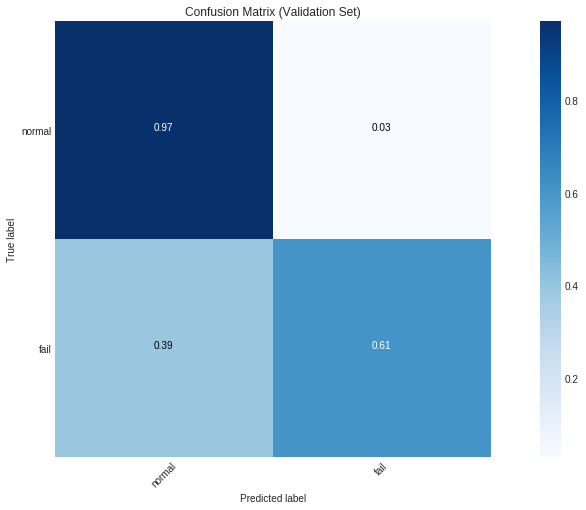

In [18]:
plt.style.use('seaborn-dark')
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(14,7))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, labels=["normal", "fail"])